In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import bias_variance_decomp
from sklearn.pipeline import Pipeline

In [3]:
X = summary_data_avg[['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'method', 'variety', 'inputs', 'protection']]
y = summary_data_avg['mean_diameter']

X.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
0,38,1128,1063757,24.6,Drilled,Krypton,Conventional,Barley
1,41,1394,1236720,24.6,Drilled,Krypton,Conventional,Barley
2,44,1630,1348259,24.6,Drilled,Krypton,Conventional,Barley
3,45,1967,1506984,24.6,Drilled,Krypton,Conventional,Barley
4,40,2256,1619377,24.6,Drilled,Krypton,Conventional,Barley


In [4]:
# Encode categoriccal variables that will be used as predictors
# Error message appearing but code seems to work.

trns = CustomTransformer().fit(X)
X = trns.transform(X)

X.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
0,38,1128,1063757,24.6,2.0,11.0,1.0,0.0
1,41,1394,1236720,24.6,2.0,11.0,1.0,0.0
2,44,1630,1348259,24.6,2.0,11.0,1.0,0.0
3,45,1967,1506984,24.6,2.0,11.0,1.0,0.0
4,40,2256,1619377,24.6,2.0,11.0,1.0,0.0


In [5]:
# Assign 'X' and 'y' values and split into seperate train and test df.
# If there is little benefit from specific indicators they can be removed.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
1654,33,588,746284,24.1,1.0,16.0,1.0,1.0
2377,33,1779,970116,2.1,0.0,20.0,1.0,2.0
1014,36,2215,1292917,36.2,2.0,4.0,1.0,0.0
2327,35,1791,990708,2.6,0.0,9.0,1.0,2.0
2284,31,2603,1844549,1.7,2.0,11.0,1.0,0.0


In [6]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection
443,38,2010,1615173,78.7,2.0,5.0,1.0,2.0
1451,62,1994,1349588,13.0,2.0,3.0,0.0,0.0
1977,32,1034,807773,31.9,1.0,22.0,1.0,2.0
1160,70,1600,1377747,18.5,2.0,21.0,0.0,3.0
3217,39,1386,937618,2.5,3.0,4.0,2.0,2.0


In [7]:
# Use the isolation forest algorithm to remove the most rogue 5% of datapoints.

print(f"The old training dataframe shape: {X_train.shape}")

clf1 = IsolationForest(max_samples=500, random_state = 10, contamination = 0.05)
preds = clf1.fit_predict(X_train)

totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

# Remove outliers from training data.
# Do not remove from test data as this is bad practice.
# Confirm removal by checking new df shape.

filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The old training dataframe shape: (2911, 8)
Total number of outliers identified is:  146
The new training dataframe shape: (2765, 8)


In [8]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid_1 = {'fit_intercept': [True, False],
                'positive': [True, False]}
   
grid_lin = GridSearchCV(LinearRegression(), param_grid_1, refit = True, verbose = 3, n_jobs=-1, cv = 2)

grid_lin.fit(PowerTransformer().fit_transform(X_train), y_train) 
 
print(grid_lin.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'fit_intercept': True, 'positive': False}


In [9]:
# Fit semi-hypertuned model and print score.

lin = Pipeline([('scaler', PowerTransformer()), ('lin', LinearRegression())])

lin.fit(X_train, y_train)
print(lin.score(X_test, y_test))

0.660254912438018


In [10]:
def hypertune_eval(param, seq_min, seq_max, seq_int, model, log = False):
    
    
    if log:
        sequence = [i for i in np.logspace(seq_min, seq_max, seq_int)]
        
    else:
        sequence = np.arange(seq_min, seq_max, seq_int)
        
    acc = []
    bias = []
    var = []
    mse = []
    
    for n in sequence:
        model[-1].set_params(**{param : n})
        model.fit(X_train, y_train)
        acc.append(model.score(X_test, y_test))
        
        mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(model, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 10, random_seed = 1)
        
        bias.append(bias_decomp)
        var.append(var_decomp)
        mse.append(mse_decomp)
        
        
    fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True, sharex=True)
    
    fig.suptitle(f'Effect of Changing {param} Parameter')
    fig.supxlabel(f'{param}')
    
    axs[0,0].plot(sequence, acc)
    axs[0,0].set_ylabel('accuracy')
    
    axs[0,1].plot(sequence, mse)
    axs[0,1].set_ylabel('mean squared error')
    
    axs[1,0].plot(sequence, bias)
    axs[1,0].set_ylabel('bias')
    
    axs[1,1].plot(sequence, var)
    axs[1,1].set_ylabel('variance')

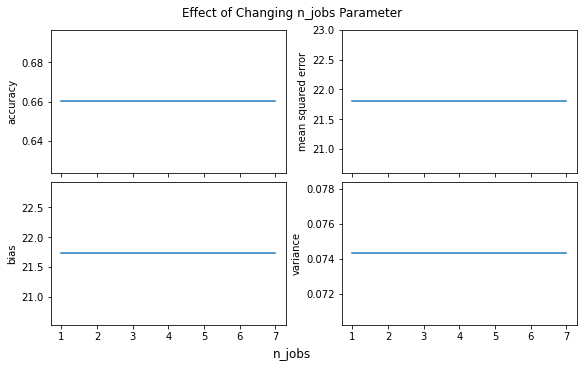

In [11]:
# Optimisation of n_estimators parameter.

hypertune_eval('n_jobs', 1, 8, 1, lin)

In [12]:
# Set parameter to optimum.
lin[-1].set_params(n_jobs = 1)
lin.fit(X_train, y_train)
print(lin.score(X_test, y_test))

mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(lin, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 30, random_seed = 1)

print(mse_decomp**0.5)
print(bias_decomp)
print(var_decomp)

lin_pred = lin.predict(X_test)

0.660254912438018
4.666420689866171
21.698074870766618
0.07740718404445436


In [13]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(lin_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)

X_test_df = pd.DataFrame(X_test, columns = ['pp2m2',
                                            'heat_units',
                                            'solar_radiation',
                                            'organic_matter',
                                            'method',
                                            'variety',
                                            'inputs',
                                            'protection']).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df = trns.inverse_transform(test_df)
test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,38,2010,1615173,78.7,Drilled,Comanche,Conventional,None,32.158159,28.955789
1,62,1994,1349588,13.0,Drilled,Belton,Baby,Barley,15.524267,11.989677
2,32,1034,807773,31.9,Blocks,Shafton,Conventional,None,20.234413,22.568750
3,70,1600,1377747,18.5,Drilled,Runner,Baby,Poly,20.343049,16.546857
4,39,1386,937618,2.5,Modules,Chiefton,Organic,None,18.709169,18.989744


In [14]:
test_df.shape

(728, 10)

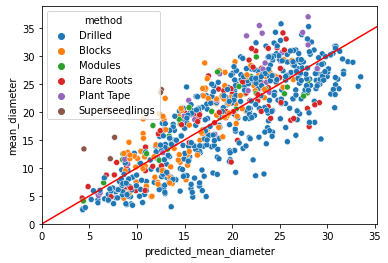

In [15]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', data = test_df, hue='method')
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()